# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
from imageio import imread

import cv2

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -q '/content/gdrive/MyDrive/Project_data.zip' -d '/content/gdrive/MyDrive'

In [6]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/val.csv').readlines())
batch_size = 64 #experiment with the batch size

In [ ]:
sample_image = os.listdir('/content/gdrive/MyDrive/Project_data/train'+'/'+ np.random.permutation(train_doc)[0 + (0)].split(';')[0])

In [ ]:
print(sample_image)

['WIN_20180926_17_24_58_Pro_00051.png', 'WIN_20180926_17_24_58_Pro_00041.png', 'WIN_20180926_17_24_58_Pro_00009.png', 'WIN_20180926_17_24_58_Pro_00025.png', 'WIN_20180926_17_24_58_Pro_00027.png', 'WIN_20180926_17_24_58_Pro_00045.png', 'WIN_20180926_17_24_58_Pro_00015.png', 'WIN_20180926_17_24_58_Pro_00061.png', 'WIN_20180926_17_24_58_Pro_00031.png', 'WIN_20180926_17_24_58_Pro_00023.png', 'WIN_20180926_17_24_58_Pro_00017.png', 'WIN_20180926_17_24_58_Pro_00007.png', 'WIN_20180926_17_24_58_Pro_00029.png', 'WIN_20180926_17_24_58_Pro_00011.png', 'WIN_20180926_17_24_58_Pro_00063.png', 'WIN_20180926_17_24_58_Pro_00057.png', 'WIN_20180926_17_24_58_Pro_00053.png', 'WIN_20180926_17_24_58_Pro_00019.png', 'WIN_20180926_17_24_58_Pro_00065.png', 'WIN_20180926_17_24_58_Pro_00047.png', 'WIN_20180926_17_24_58_Pro_00035.png', 'WIN_20180926_17_24_58_Pro_00043.png', 'WIN_20180926_17_24_58_Pro_00013.png', 'WIN_20180926_17_24_58_Pro_00033.png', 'WIN_20180926_17_24_58_Pro_00055.png', 'WIN_20180926_17_24_58_P

In [ ]:
sample_path = '/content/gdrive/MyDrive/Project_data/train'+'/'+ train_doc[0].split(';')[0]
sample = imread(sample_path+'/'+os.listdir(sample_path)[0])

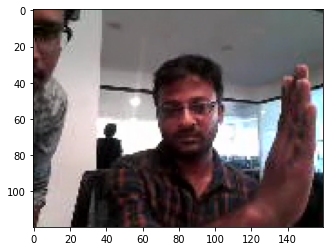

In [ ]:
plt.imshow(sample)
plt.show()

In [ ]:
sample.shape

(120, 160, 3)

In [7]:
img_height = 120
img_width = 120
channels = 3

In [8]:
num_classes = 5
print ('# classification classes =', num_classes)

# classification classes = 5


In [ ]:
sample = resize(sample,(img_height,img_width,3))

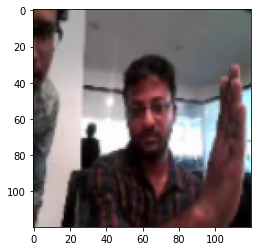

In [ ]:
plt.imshow(sample)
plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,16)).astype(int) #[0,2,4,6,8,10,12,14,16,18,20,22,24,25,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) #calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # resize
                    image = resize(image,(img_height,img_width,3))
                    #if image.shape[1] == 160:
                      #image = imresize(image[:,20:140,:],(50,50)).astype(np.float32)
                   # else:
                      #image = imresize(image,(50,50)).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        rem_image = len(t)%batch_size
        if (rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # resize
                    image = resize(image,(img_height,img_width,3))
                    #if image.shape[1] == 160:
                      #image = imresize(image[:,20:140,:],(50,50)).astype(np.float32)
                   # else:
                      #image = imresize(image,(50,50)).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


##Generator with Data Augmentation

In [9]:
batch_size = 25

In [10]:
augment = True
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,16)).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) #calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches # batch_labels is the one hot representation of the output
            batch_data, batch_labels= one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
            yield batch_data, batch_labels

        #the code for the remaining data points which are left after full batches
        remaining_seq=len(t)%batch_size        
        if (remaining_seq != 0):
            batch_data, batch_labels= one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
            yield batch_data, batch_labels 

def one_batch_data(source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
     #print( 'Source path = ', source_path, '; batch size =', batch_size)

     seq_len = remaining_seq if remaining_seq else batch_size

     batch_data = np.zeros((seq_len,len(img_idx),img_height,img_width,channels)) 
     batch_labels = np.zeros((seq_len,num_classes)) 
    
     if (augment): 
        batch_data_aug = np.zeros((seq_len,len(img_idx),img_height,img_width,channels))
        
     for folder in range(seq_len): 
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
        for idx,item in enumerate(img_idx):           
              
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shape

            #image reading and image resizing
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image_resized=resize(image,(img_height,img_width,3))
            
            # normalize and feed in the image
            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
          
            if (augment):
                shifted = cv2.warpAffine(image, 
                                         np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                         (image.shape[1], image.shape[0]))
                    
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 

                # cropping the images to have the targeted gestures and remove the noise from the images.
                cropped=shifted[x0:x1,y0:y1,:]
                    
                image_resized=resize(cropped,(img_height,img_width,3))
                M = cv2.getRotationMatrix2D((img_width//2,img_height//2),np.random.randint(-10,10), 1.0)
                rotated = cv2.warpAffine(image_resized, M, (img_width, img_height))

                batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255                
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1           
    
     if (augment):
        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])
        
     return (batch_data,batch_labels)

# For CNN+RNN

Please select further lesser no of images as the computation part is going to be too heavy. My advice will be to select 12 to 14 images.

Rest all of the above code will remain the same.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

__Why are we using datetime?__

Because we will be creating multiple models and we dont wish to overwrite a new model over the older one. Therefore, saving it along with the timestamp helps.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Project_data/train'
val_path = '/content/gdrive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 35


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

from keras.regularizers import l2

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [25]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1) #write the REducelronplateau code here
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### CONV3D - Model 1 (elu+Adam)

In [14]:
#write your model here
model = Sequential()

model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(16,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

# model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('elu'))
# model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 100, 100, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 16, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 50, 100, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 50, 100, 32)    13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 50, 100, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 50, 100, 32)    0

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
#Ablation Experiment
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/5


InvalidArgumentError: ignored

**16% validation accuracy** - 18x50x50  - 90l  
**38% validation accuracy** - 18x50x50 - 50l

#### CONV3D - Model 2 (relu+Adam+l2)

In [ ]:
#write your model here
model = Sequential()

model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(10,50,50,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

#model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 10, 50, 50, 64)    5248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 50, 50, 64)    256       
_________________________________________________________________
activation_3 (Activation)    (None, 10, 50, 50, 64)    0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 25, 50, 64)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 5, 25, 50, 128)    221312    
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 25, 50, 128)    512       
_________________________________________________________________
activation_4 (Activation)    (None, 5, 25, 50, 128)   

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 64
Epoch 1/5
11/11 [==============================] - 2290s 225s/step - loss: 35.2202 - categorical_accuracy: 0.2158 - val_loss: 326.8716 - val_categorical_accuracy: 0.2300
Epoch 2/5
11/11 [==============================] - 407s 37s/step - loss: 15.3571 - categorical_accuracy: 0.3421 - val_loss: 250.5556 - val_categorical_accuracy: 0.2500
Epoch 3/5
11/11 [==============================] - 401s 36s/step - loss: 10.9147 - categorical_accuracy: 0.3628 - val_loss: 63.3177 - val_categorical_accuracy: 0.2200
Epoch 4/5
11/11 [==============================] - 409s 37s/step - loss: 9.5822 - categorical_accuracy: 0.3264 - val_loss: 32.6211 - val_categorical_accuracy: 0.2500
Epoch 5/5
11/11 [==============================] - 411s 37s/step - loss: 8.5919 - categorical_accuracy: 0.3760 - val_loss: 28.4989 - val_categorical_accuracy: 0.2000


**24% validation accuracy - adam+l2** - 18x84x84 90l  
**49% - sgd+l2** - 18x50x50 50l

###CONV2D+LTSM

In [ ]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import LSTM

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
                 input_shape=(18,50,50,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (2, 2))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
# compile it
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])
# summary of model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 18, 50, 50, 16)    208       
_________________________________________________________________
activation_27 (Activation)   (None, 18, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 18, 50, 50, 16)    64        
_________________________________________________________________
time_distributed_8 (TimeDist (None, 18, 49, 49, 16)    1040      
_________________________________________________________________
activation_28 (Activation)   (None, 18, 49, 49, 16)    0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 18, 49, 49, 16)    64        
_________________________________________________________________
time_distributed_9 (TimeDist (None, 18, 24, 24, 16)   

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/35
 9/11 [=======================>......] - ETA: 8s - loss: 2.8092 - categorical_accuracy: 0.1847 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


11/11 [==============================] - 58s 6s/step - loss: 2.7923 - categorical_accuracy: 0.1932 - val_loss: 2.6768 - val_categorical_accuracy: 0.2000
Epoch 2/35
11/11 [==============================] - 59s 6s/step - loss: 2.6641 - categorical_accuracy: 0.2161 - val_loss: 2.5845 - val_categorical_accuracy: 0.3200
Epoch 3/35
11/11 [==============================] - 54s 5s/step - loss: 2.6209 - categorical_accuracy: 0.2497 - val_loss: 2.5771 - val_categorical_accuracy: 0.2700
Epoch 4/35
11/11 [==============================] - 59s 6s/step - loss: 2.5461 - categorical_accuracy: 0.3202 - val_loss: 2.5293 - val_categorical_accuracy: 0.3300
Epoch 5/35
11/11 [==============================] - 55s 6s/step - loss: 2.5333 - categorical_accuracy: 0.3389 - val_loss: 2.5084 - val_categorical_accuracy: 0.3500
Epoch 6/35
11/11 [==============================] - 58s 6s/step - loss: 2.4881 - categorical_accuracy: 0.3555 - val_loss: 2.5348 - val_categorical_accuracy: 0.3000
Epoch 7/35
11/11 [=========

**85 vs 62% accuracy** - 18x84x84  13l  
**53 vs 44% accuracy** - 18x50x50  -5,006,181

###CONV2D+GRU

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
                 input_shape=(18,50,50,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (2, 2))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))
model.add(GRU(256, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
# compile it
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])

# summary of model
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 18, 50, 50, 16)    208       
_________________________________________________________________
activation_33 (Activation)   (None, 18, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 18, 50, 50, 16)    64        
_________________________________________________________________
time_distributed_15 (TimeDis (None, 18, 49, 49, 16)    1040      
_________________________________________________________________
activation_34 (Activation)   (None, 18, 49, 49, 16)    0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 18, 49, 49, 16)    64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 18, 24, 24, 16)   

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=35, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/35
 8/11 [====================>.........] - ETA: 13s - loss: 2.8886 - categorical_accuracy: 0.1799

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


11/11 [==============================] - 61s 6s/step - loss: 2.8717 - categorical_accuracy: 0.1842 - val_loss: 2.7813 - val_categorical_accuracy: 0.2400
Epoch 2/35
11/11 [==============================] - 55s 5s/step - loss: 2.6962 - categorical_accuracy: 0.2606 - val_loss: 2.6710 - val_categorical_accuracy: 0.3000
Epoch 3/35
11/11 [==============================] - 58s 6s/step - loss: 2.6099 - categorical_accuracy: 0.2822 - val_loss: 2.6957 - val_categorical_accuracy: 0.2200
Epoch 4/35
11/11 [==============================] - 55s 5s/step - loss: 2.5840 - categorical_accuracy: 0.2956 - val_loss: 2.6807 - val_categorical_accuracy: 0.2400

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 5/35
11/11 [==============================] - 58s 6s/step - loss: 2.4916 - categorical_accuracy: 0.3603 - val_loss: 2.6353 - val_categorical_accuracy: 0.2300
Epoch 6/35
11/11 [==============================] - 55s 6s/step - loss: 2.4095 - categorical_accuracy: 0.4133 -

**81 vs 68% accuracy** - 18x84x84  - 10l  
**48 vs 39% accuracy** - 18x50x50 - 3,761,509  

In [ ]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import LSTM,GRU
from keras.regularizers import l2

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same'),
                 input_shape=(15,50,50,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))
model.add(GRU(128, return_sequences=False, dropout=0.5))
model.add(Dense(128,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 15, 50, 50, 16)    448       
_________________________________________________________________
activation_20 (Activation)   (None, 15, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 15, 50, 50, 16)    64        
_________________________________________________________________
time_distributed_28 (TimeDis (None, 15, 25, 25, 16)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 15, 25, 25, 32)    4640      
_________________________________________________________________
activation_21 (Activation)   (None, 15, 25, 25, 32)    0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 15, 25, 25, 32)   

In [ ]:
history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
11/11 [==============================] - 90s 8s/step - loss: 3.0732 - categorical_accuracy: 0.2107 - val_loss: 3.1468 - val_categorical_accuracy: 0.2200
Epoch 2/10
11/11 [==============================] - 87s 8s/step - loss: 2.8072 - categorical_accuracy: 0.3030 - val_loss: 3.5032 - val_categorical_accuracy: 0.2400
Epoch 3/10
11/11 [==============================] - 87s 8s/step - loss: 2.6413 - categorical_accuracy: 0.4272 - val_loss: 3.4297 - val_categorical_accuracy: 0.2400

Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
Epoch 4/10
11/11 [==============================] - 88s 8s/step - loss: 2.5106 - categorical_accuracy: 0.5206 - val_loss: 3.4548 - val_categorical_accuracy: 0.2200
Epoch 5/10
11/11 [==============================] - 86s 8s/step - loss: 2.5308 - categorical_accuracy: 0.4691 - val_loss: 3.3774 - val_categorical_accuracy: 0.2300

Epoch 00005: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
Epoch 6/10
11/11 

###CONV3D (15x50x50)

In [ ]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
       input_shape=(15,50,50,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu')) #kernel_regularizer=l2(0.01), 
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
#optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 50, 50, 16)    1312      
_________________________________________________________________
activation_3 (Activation)    (None, 15, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 50, 50, 16)    64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 25, 25, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 25, 25, 32)     4128      
_________________________________________________________________
activation_4 (Activation)    (None, 7, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 25, 25, 32)    

In [ ]:
history1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=35, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=5)

Epoch 6/35
11/11 [==============================] - 114s 10s/step - loss: 1.2652 - categorical_accuracy: 0.5279 - val_loss: 2.4605 - val_categorical_accuracy: 0.2300
Epoch 7/35
11/11 [==============================] - 114s 10s/step - loss: 1.1776 - categorical_accuracy: 0.5339 - val_loss: 2.1081 - val_categorical_accuracy: 0.2800
Epoch 8/35
11/11 [==============================] - 114s 10s/step - loss: 1.1121 - categorical_accuracy: 0.5732 - val_loss: 1.9397 - val_categorical_accuracy: 0.3000
Epoch 9/35
11/11 [==============================] - 116s 11s/step - loss: 1.0908 - categorical_accuracy: 0.5943 - val_loss: 1.8132 - val_categorical_accuracy: 0.2700
Epoch 10/35
11/11 [==============================] - 113s 10s/step - loss: 1.0479 - categorical_accuracy: 0.6169 - val_loss: 1.8224 - val_categorical_accuracy: 0.2700
Epoch 11/35
11/11 [==============================] - 115s 11s/step - loss: 0.9459 - categorical_accuracy: 0.6094 - val_loss: 1.5169 - val_categorical_accuracy: 0.3300
Ep

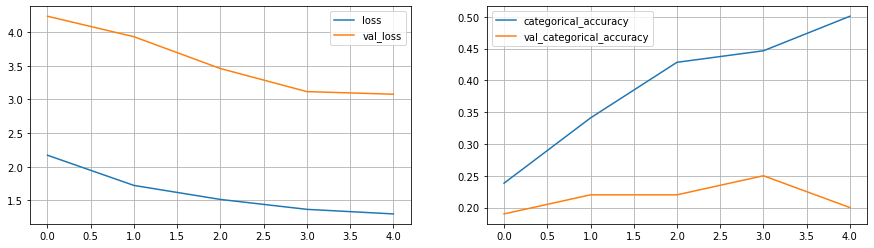

In [ ]:
plot(history)

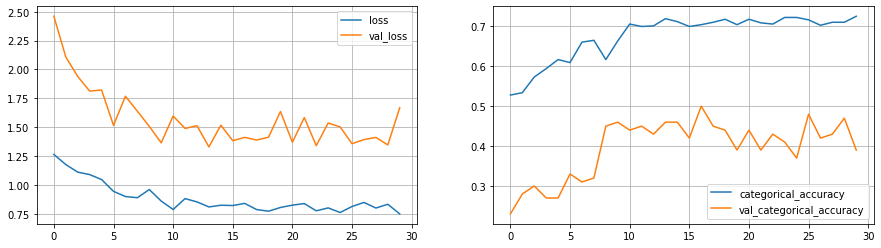

In [ ]:
plot(history1)

###CONV3D (16x100x100) - 398,213


In [ ]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
      input_shape=(16,img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_10 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_11 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 50, 50, 32)    

In [ ]:
history11 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 64
Epoch 1/5
11/11 [==============================] - 1050s 105s/step - loss: 2.1606 - categorical_accuracy: 0.2512 - val_loss: 6.3613 - val_categorical_accuracy: 0.2400
Epoch 2/5
11/11 [==============================] - 165s 16s/step - loss: 1.3992 - categorical_accuracy: 0.4573 - val_loss: 5.3693 - val_categorical_accuracy: 0.2400
Epoch 3/5
11/11 [==============================] - 168s 17s/step - loss: 1.1160 - categorical_accuracy: 0.5626 - val_loss: 5.6696 - val_categorical_accuracy: 0.1800
Epoch 4/5
11/11 [==============================] - 163s 16s/step - loss: 0.9448 - categorical_accuracy: 0.6065 - val_loss: 4.0594 - val_categorical_accuracy: 0.2400
Epoch 5/5
11/11 [==============================] - 171s 17s/step - loss: 0.7742 - categorical_accuracy: 0.7109 - val_loss: 2.9712 - val_categorical_accuracy: 0.3200


In [ ]:
history12 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=5)

Epoch 6/30
11/11 [==============================] - 165s 16s/step - loss: 0.8139 - categorical_accuracy: 0.7014 - val_loss: 2.7370 - val_categorical_accuracy: 0.2000
Epoch 7/30
11/11 [==============================] - 173s 17s/step - loss: 0.7493 - categorical_accuracy: 0.7300 - val_loss: 1.9958 - val_categorical_accuracy: 0.3000
Epoch 8/30
11/11 [==============================] - 164s 16s/step - loss: 0.7043 - categorical_accuracy: 0.7481 - val_loss: 1.9102 - val_categorical_accuracy: 0.2600
Epoch 9/30
11/11 [==============================] - 170s 17s/step - loss: 0.6203 - categorical_accuracy: 0.7994 - val_loss: 1.7299 - val_categorical_accuracy: 0.2800
Epoch 10/30
11/11 [==============================] - 161s 16s/step - loss: 0.6019 - categorical_accuracy: 0.8220 - val_loss: 1.5689 - val_categorical_accuracy: 0.3600
Epoch 11/30
11/11 [==============================] - 163s 16s/step - loss: 0.5680 - categorical_accuracy: 0.8205 - val_loss: 1.7134 - val_categorical_accuracy: 0.3700
Ep

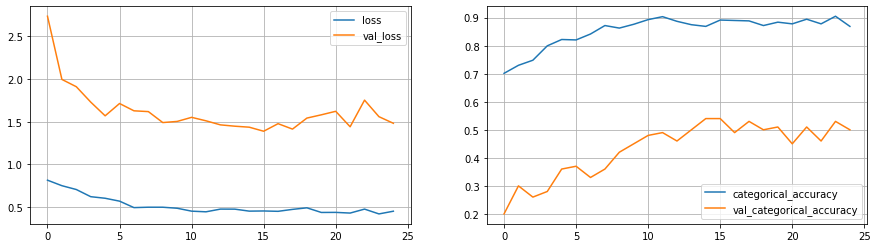

In [ ]:
plot(history12)

###CONV3D (16x120x120) - 504,709


In [28]:
model = Sequential()
model.add(Conv3D(16, (2, 2, 2), padding='same',
      input_shape=(16,img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
model.add(Flatten())
model.add(Dense(256,activation='relu')
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu')))#kernel_regularizer=l2(0.01)
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_15 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_16 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 60, 60, 32)    

In [29]:
history15 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - 247s 11s/step - loss: 2.1325 - categorical_accuracy: 0.3142 - val_loss: 1.8107 - val_categorical_accuracy: 0.2600
Epoch 2/5
23/23 [==============================] - 243s 11s/step - loss: 1.3766 - categorical_accuracy: 0.5118 - val_loss: 2.7935 - val_categorical_accuracy: 0.2300
Epoch 3/5
23/23 [==============================] - 239s 11s/step - loss: 1.2157 - categorical_accuracy: 0.5563 - val_loss: 3.5828 - val_categorical_accuracy: 0.1900

Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
Epoch 4/5
23/23 [==============================] - 235s 11s/step - loss: 1.1874 - categorical_accuracy: 0.5672 - val_loss: 4.3473 - val_categorical_accuracy: 0.2250
Epoch 5/5
23/23 [==============================] - 244s 11s/step - loss: 1.2060 - categorical_accuracy: 0.5717 - val_loss: 4.7898 - val_categorical_accuracy: 0.2100

Epoch 00005: Red

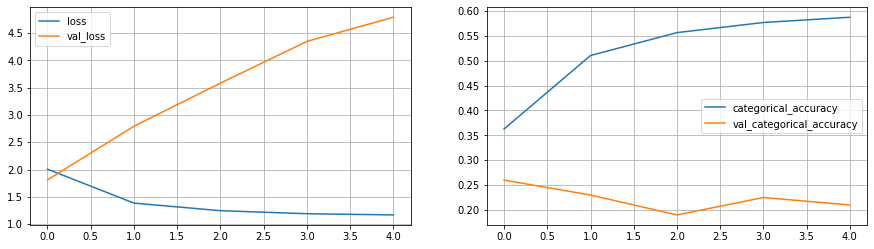

In [30]:
plot(history15)

#Arunima

In [13]:
# Parameters initialization
no_of_rows = 120   # X dimension of the image
no_of_cols = 120   # Y dimesnion of the image
no_of_frames = 30  # lenght of the video frames
no_of_channels = 3 # numbe of channels in images 3 for color(RGB)

In [14]:
def load_batch_data(source_path, folder_list, batch_size, batch, t, model_type, validation=0):
    if model_type == 'conv3D':
        batch_data = np.zeros((batch_size, no_of_frames, no_of_rows, no_of_cols, no_of_channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3
    else:
        batch_data = np.zeros((batch_size, no_of_rows, no_of_cols, no_of_channels))
    #print(batch_data.shape)
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    img_idx = list(range(0,30,1)) #create a list of image numbers you want to use for a particular video
    
    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
        
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            #print(idx,item)
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
               
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            #image = crop_image(image)
            image = cv2.resize(image, (no_of_rows,no_of_cols), interpolation = cv2.INTER_AREA)
            
            normalizedImg = np.zeros((120, 120, 3))
            normalizedImg = cv2.normalize(image, np.zeros((120, 120,3)) , 0, 1, cv2.NORM_MINMAX)
            #print(normalizedImg.shape)
            
            if model_type == 'conv3D':
                batch_data[folder,idx] = normalizedImg #normalise and feed in the image
            else:
                batch_data[folder] = normalizedImg
         
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #print(batch_data.shape)
            
    return (batch_data,batch_labels)


def generator(source_path, folder_list, batch_size, model_type, validation=0):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    while True:
        # t contains list of file name
        # 'WIN_20180925_17_44_57_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield load_batch_data(source_path, folder_list, batch_size, batch, t, model_type) #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        remainder = len(folder_list) % batch_size
        if (remainder > 0):
            batch_size = remainder
            yield load_batch_data(source_path, folder_list, batch_size, batch, t, model_type)

In [17]:
#write your model here

no_of_rows = 120   # X dimension of the image
no_of_cols = 120   # Y dimesnion of the image
no_of_frames = 30  # lenght of the video frames
no_of_channels = 3 # numbe of channels in images 3 for color(RGB)

# Input
input_shape=(no_of_frames, no_of_rows, no_of_cols, no_of_channels)

# Define model
def conv3d_model():
    model = Sequential()

    model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(5, activation='softmax'))
    
    return model

In [18]:
from keras.optimizers import Nadam, Adam, SGD
# optimiser = Adam() #write your optimizer
optimiser = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model = conv3d_model()
model.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 16)    0

In [15]:
train_generator = generator(train_path, train_doc, 25, 'conv3D')
val_generator = generator(val_path, val_doc, 25, 'conv3D')

In [21]:
#batch_size = 10
num_epochs = 25
history22 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 25
Epoch 1/25
27/27 [==============================] - 5086s 194s/step - loss: 1.9322 - categorical_accuracy: 0.1789 - val_loss: 1.7469 - val_categorical_accuracy: 0.1900
Epoch 2/25
27/27 [==============================] - 431s 16s/step - loss: 1.7169 - categorical_accuracy: 0.2436 - val_loss: 1.5829 - val_categorical_accuracy: 0.2600
Epoch 3/25
27/27 [==============================] - 427s 16s/step - loss: 1.5495 - categorical_accuracy: 0.2427 - val_loss: 1.4341 - val_categorical_accuracy: 0.2500
Epoch 4/25
27/27 [==============================] - 432s 16s/step - loss: 1.3979 - categorical_accuracy: 0.2852 - val_loss: 1.3011 - val_categorical_accuracy: 0.3200
Epoch 5/25
27/27 [==============================] - 432s 16s/step - loss: 1.2669 - categorical_accuracy: 0.3325 - val_loss: 1.1821 - val_categorical_accuracy: 0.2400
Epoch 6/25
27/27 [==============================] - 435s 16s/step - loss: 1.1477 - categoric

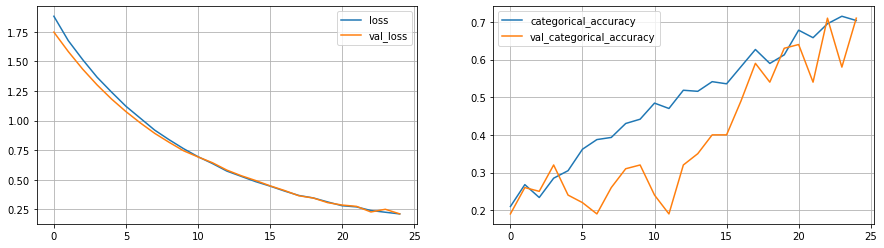

In [22]:
plot(history22)